In [1]:
import tensorflow as tf

# List physical devices
devices = tf.config.list_physical_devices()
for device in devices:
    print(f"Device: {device}")

# Check if GPU is available
gpu = tf.config.list_physical_devices('GPU')
if gpu:
    print(f"Using GPU: {gpu}")
else:
    print("Using CPU")


Device: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
import tensorflow as tf
import os
import glob
import random
import math

# Import Data

## Function to load and preprocess images

In [7]:
def load_image(image_path, mask_path):
    
    # Load image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]

    return image, mask

## Function to build a 2D transformation matrix

In [8]:
def build_2d_transform_matrix(flip=None, offset=None, scale=None, rotate=None):
    transform = tf.eye(3)

    # Apply flip
    if flip and random.random() > 0.5:
        transform = tf.linalg.tensor_diag([flip, flip, 1.0]) @ transform
      

    # Apply offset
    if offset:
        offset_x = random.uniform(-offset, offset)
        offset_y = random.uniform(-offset, offset)
        offset_matrix = tf.convert_to_tensor([[1, 0, offset_x],
                                              [0, 1, offset_y],
                                              [0, 0, 1]], dtype=tf.float32)
        transform = offset_matrix @ transform
        # if offset is a random number x (offset_x) , y (offset_y) generate ofset in range [-offset, offset]

    # Apply scale
    if scale:
        scale_x = 1.0 + random.uniform(-scale, scale)
        scale_y = 1.0 + random.uniform(-scale, scale)
        scale_matrix = tf.convert_to_tensor([[scale_x, 0, 0],
                                             [0, scale_y, 0],
                                             [0, 0, 1]], dtype=tf.float32)
        transform = scale_matrix @ transform
        # in range [1 - scale, 1 + scale]

    # Apply rotation
    if rotate:
        angle_rad = random.uniform(-rotate, rotate) * math.pi / 180
        rotation_matrix = tf.convert_to_tensor([[tf.cos(angle_rad), -tf.sin(angle_rad), 0],
                                                [tf.sin(angle_rad), tf.cos(angle_rad), 0],
                                                [0, 0, 1]], dtype=tf.float32)
        transform = rotation_matrix @ transform
        # in range [-rotate, rotate]

    # Extract the 2x3 part of the matrix and flatten it to [6]
    transform = transform[:2, :]
    transform = tf.reshape(transform, [6])

    # Append [0, 0] to make it [8] elements
    transform = tf.concat([transform, tf.constant([0.0, 0.0])], axis=0)

    return transform

## Function to apply data augmentation

In [9]:
def data_augmentation(image, mask, flip=None, offset=None, scale=None, rotate=None, noise=None):
    # Build the 2D transformation matrix
    transform_matrix = build_2d_transform_matrix(flip, offset, scale, rotate)

    # The transformation matrix needs to be in shape [1, 8]
    transform_matrix = tf.reshape(transform_matrix, [1, 8])

    # Apply affine transformation using ImageProjectiveTransformV2
    image_shape = tf.shape(image)[:2]
    image = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(image, 0),
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="BILINEAR")[0]

    mask = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(mask, 0), # convert to [1, height, width, channels]
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="NEAREST")[0]

    # random noise
    if noise:
        noise_tensor = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise, dtype=tf.float32)
        image = tf.add(image, noise_tensor)

    return image, tf.cast(mask > 0.5, tf.float32) # in mask Converts all values ​​greater than 0.5 to 1 and all others to 0

## Shuffle and split the data

In [10]:
image_dir = r"C:\Users\shima\frames"
mask_dir=r"C:\Users\shima\masks"

In [11]:
# Get list of image and mask file paths
image_paths = glob.glob(os.path.join(image_dir, '*.png'))
mask_paths = [os.path.join(mask_dir, os.path.basename(im)) for im in image_paths]

In [13]:
# Shuffle and split the data
N = len(image_paths)
ixRand = list(range(N)) # list of 0 to N−1
random.shuffle(ixRand)

train_image_paths = [image_paths[i] for i in ixRand[:round(N * 0.8)]]
train_mask_paths = [mask_paths[i] for i in ixRand[:round(N * 0.8)]]

val_image_paths = [image_paths[i] for i in ixRand[round(N * 0.8):]]
val_mask_paths = [mask_paths[i] for i in ixRand[round(N * 0.8):]]

## Create TensorFlow Datasets

In [15]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

2024-09-12 20:41:41.809288: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-09-12 20:41:41.809319: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-12 20:41:41.809327: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-12 20:41:41.809365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 20:41:41.809375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Apply Loading and Preprocessing Functions

In [16]:
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) #map implement load_image on every element
train_dataset = train_dataset.map(lambda x, y: data_augmentation(x, y, flip=1, offset=0.1, scale=0.2, rotate=10, noise=0.1), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
# Check loaded data
for image, mask in train_dataset.take(1):
    print(image.shape, mask.shape)

(32, 112, 112, 3) (32, 112, 112, 1)


2024-09-12 20:41:46.225625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39362642..1.2069645].


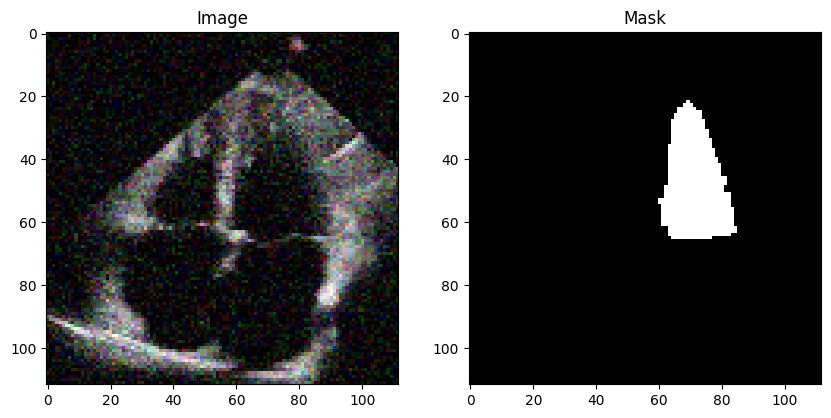

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4232742..1.1008854].


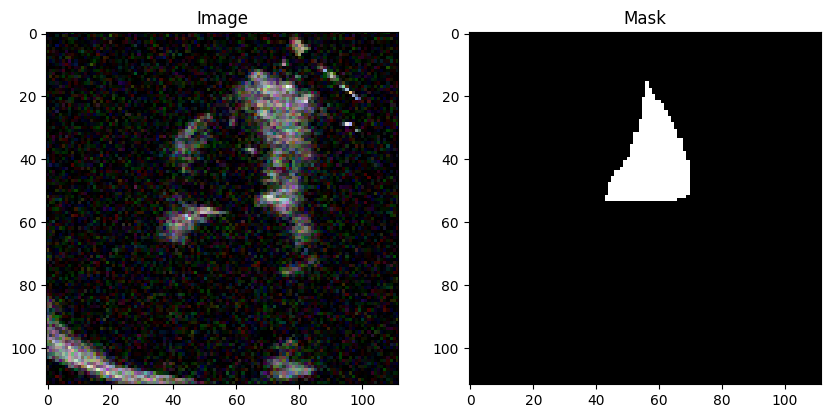

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38170305..1.2215887].


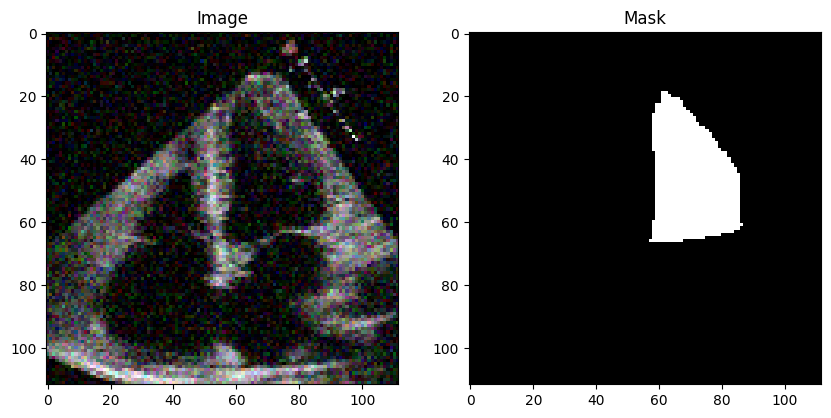

2024-09-12 21:44:15.044219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [47]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to display image and mask
def display_image_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.show()

# Take a batch of images and masks from the dataset
for images, masks in train_dataset.take(1):
    for i in range(3):  # Display 3 images and their masks
        image = images[i].numpy()
        mask = masks[i].numpy()
        display_image_mask(image, mask)